In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft, ifft
from scipy import signal
from scipy.fft import fftshift
import scipy
from mpl_toolkits.mplot3d.axes3d import Axes3D
 
from numpy.fft import fftn, ifftn


from pycbc.waveform import td_approximants, fd_approximants
from pycbc.waveform import get_td_waveform
from pycbc.filter import highpass_fir, matched_filter
from pycbc.filter import highpass_fir, lowpass_fir
from pycbc.waveform import get_fd_waveform
from pycbc.psd import welch, interpolate

import pylab
from pycbc import types, waveform, frame
import pycbc.noise
import pycbc.psd
from pycbc.catalog import Merger
from pycbc.detector import Detector


from scipy.interpolate import interp1d

import sys 
from pycbc.filter import sigma


import random

from tqdm import tqdm


# Noise generation

In [9]:
# load and whiten noise waveforms




for i in range(2,11):

    tsL1=np.load('/Volumes/EXTERNAL/SGWB_data/51k noise/L_N51_'+str(i)+'.npy')
    tsH1=np.load('/Volumes/EXTERNAL/SGWB_data/51k noise/H_N51_'+str(i)+'.npy')
    
    L1noise4096=np.array(tsL1)
    H1noise4096=np.array(tsH1)

    Tot_t=50000 #30000
    ul=Tot_t-50
    ll=50

    L1noise=L1noise4096[0*4096:Tot_t*4096]
    H1noise=H1noise4096[0*4096:Tot_t*4096]

    del tsL1
    del tsH1

    del L1noise4096
    del H1noise4096

    L1noise_ts=types.TimeSeries(L1noise, delta_t=1.0 / 4096)
    H1noise_ts=types.TimeSeries(H1noise, delta_t=1.0 / 4096)

    del L1noise
    del H1noise
    
    psdL1 = interpolate(welch(L1noise_ts), 1.0 / L1noise_ts.duration)
    psdH1 = interpolate(welch(H1noise_ts), 1.0 / H1noise_ts.duration)

    L1_N_white = (L1noise_ts.to_frequencyseries() / psdL1 ** 0.5).to_timeseries()
    H1_N_white = (H1noise_ts.to_frequencyseries() / psdH1 ** 0.5).to_timeseries()
    
    np.save('/Volumes/EXTERNAL/SGWB_data/51k_wN/L_51kN_w'+str(i)+'.npy',L1_N_white[ll*4096:ul*4096])

    np.save('/Volumes/EXTERNAL/SGWB_data/51k_wN/H_51k_w'+str(i)+'.npy',H1_N_white[ll*4096:ul*4096])
    
    del L1_N_white
    del H1_N_white



# waveform generation

In [2]:
# time shift function

def shift_elements(arr, num, fill_value):
    result = np.empty_like(arr)
    if num > 0:
        result[:num] = fill_value
        result[num:] = arr[:-num]
    elif num < 0:
        result[num:] = fill_value
        result[:num] = arr[-num:]
    else:
        result[:] = arr
    return result

In [6]:
# without overlap


#parameters

M_min=10
M_max=90


np.random.seed(130000)

timeLag=[]


sgwbTSl1=[]
sgwbTSh1=[]
sgwbTSv1=[]



for i in tqdm(range(1,10)):
    
    
    D=np.random.randint(6000,30000)
    m1=np.random.randint(M_min,M_max)
    m2=np.random.randint(M_min,M_max)
    a1=np.random.uniform(-.8,.8)
    a2=np.random.uniform(-.8,.8)


    
    hp, hc = get_td_waveform(approximant='IMRPhenomXAS',
                                     mass1=m1,
                                     mass2=m2,
                                     spin1z=a1,
                                     spin2z=a2,                             
                                     delta_t=1.0/4096,
                                     distance=D,
                                     f_lower=5)
    
    
    
    
    end_time=random.randint(1238303737,1238404000)
    declination = random.uniform(-1.56,1.56)
    right_ascension = random.uniform(0,6.1)
    polarization = random.uniform(0,6.1)
    
    
    
    
    det_h1 = Detector('H1')
    det_l1 = Detector('L1')
    det_v1 = Detector('V1')


    # Choose a GPS end time, sky location, and polarization phase for the merger
    # NOTE: Right ascension and polarization phase runs from 0 to 2pi
    #       Declination runs from pi/2. to -pi/2 with the poles at pi/2. and -pi/2.

    hp.start_time += end_time
    hc.start_time += end_time

    signal_h1 = det_h1.project_wave(hp,hc,  right_ascension, declination, polarization)
    signal_l1 = det_l1.project_wave(hp, hc, right_ascension, declination, polarization)
    signal_v1 = det_v1.project_wave(hp, hc, right_ascension, declination, polarization)


    signal_h1_np=np.array(signal_h1)
    signal_l1_np=np.array(signal_l1)
    signal_v1_np=np.array(signal_v1)
    
    th=signal_h1.sample_times
    tl=signal_l1.sample_times
    
    shift=int((np.array(th)[10]-np.array(tl)[10])*4096)

    
    
    #shift=random.randint(-41,41)
    
    signal_h1_np_s=shift_elements(signal_h1_np, shift, 0)
    signal_v1_np_s=shift_elements(signal_v1_np, shift, 0)

    

    signal_l1_np=signal_l1_np[-3*4096:]  #4sec for 51k dataset
    signal_h1_np=signal_h1_np_s[-3*4096:]
    signal_v1_np=signal_v1_np_s[-4*4096:]

    
   

    
    #sampling the time interval between events randomly
    

    
    x=np.random.randint(0*4096,(1/2)*4096)
    #x=np.random.randint(0*4096,100*4096) #for 51k dataset

    buff=np.zeros(x)
    
    sgwbTSl1.append(buff.tolist()) #L1 detector
    sgwbTSl1.append(signal_l1_np.tolist())
    
    sgwbTSh1.append(buff.tolist())        #H1 detector
    sgwbTSh1.append(signal_h1_np.tolist())

    sgwbTSv1.append(buff.tolist())     #V1 detector
    sgwbTSv1.append(signal_v1_np.tolist())   
    


    


100%|█████████████████████████████████████████████| 9/9 [00:03<00:00,  3.00it/s]


In [7]:
#flatten the output and obtain np array


flatL1 = list(np.concatenate(sgwbTSl1). flat)
del sgwbTSl1

flatH1 = list(np.concatenate(sgwbTSh1). flat)

del sgwbTSh1

flatV1 = list(np.concatenate(sgwbTSv1). flat)

del sgwbTSv1

sgwbTSl1np=np.array(flatL1)

del flatL1

sgwbTSh1np=np.array(flatH1)

del flatH1

sgwbTSv1np=np.array(flatV1)

del flatV1





29.0673828125

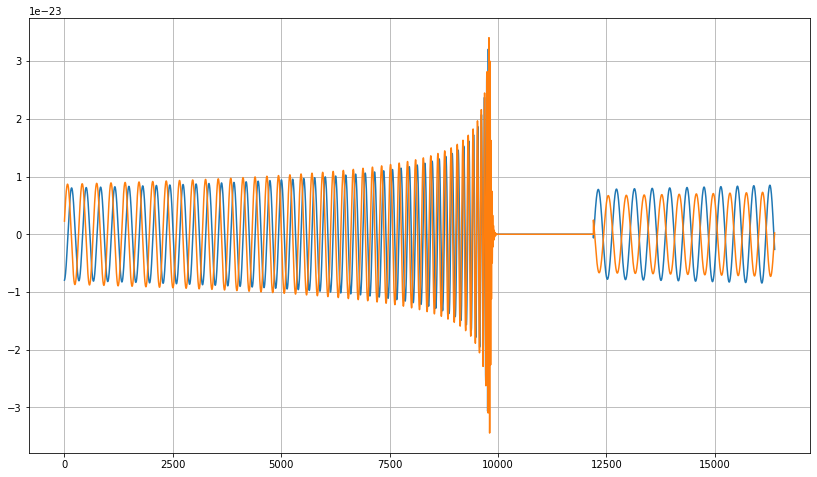

In [9]:
#check total time of data
(len(sgwbTSh1np))/4096


plt.figure(figsize=(14,8))



plt.plot(sgwbTSh1np[10*4096:14*4096])
plt.plot(sgwbTSl1np[10*4096:14*4096])

plt.grid()

In [ ]:
# save data

np.save('/Users/ramitdey/Documents/Documents/SGWB_data/sgwbl1_high1k_15.npy',sgwbTSl1np[4*4096:])
np.save('/Users/ramitdey/Documents/Documents/SGWB_data/sgwbh1_high1k_15.npy',sgwbTSh1np[4*4096:])
